In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## data choice modification name

In [39]:
mods = ''

## Demand data preprocessing

In [40]:
demand_raw = pd.read_csv('./pl_demand.csv')

In [41]:
nrg_column = 'Krajowe zużycie energii'
#nrg_column = 'Krajowa produkcja energii'

demand = demand_raw[['Rok', nrg_column]].dropna()
demand = pd.DataFrame([demand[c].astype(int) for c in demand]).T
demand = demand.rename(columns = {'Rok': 'Year', nrg_column: 'Electricity demand'})
demand = demand.set_index('Year')
demand.describe()

,Electricity demand
count,31.000000
mean,147946.193548
std,12811.595106
min,128803.000000
25%,137097.000000
50%,144838.000000
75%,157944.500000
max,170932.000000


## Criteria Data preprocessing

In [42]:
criteria_raw = pd.read_csv('./pl_data_2.csv', dtype=str)

In [43]:
criteria_raw.at[13, 'Subject Descriptor'] = 'ODEX_2'
criteria_raw = criteria_raw.replace('n.a.', np.NaN)

In [44]:
names = criteria_raw['Subject Descriptor'].tolist()
units = criteria_raw['Units'].tolist()
criteria_names = []
for name, unit in zip(names, units):
    n = name.replace('Gross domestic product', 'GDP')
    unit = str(unit)
    unit = 'PLN' if 'National currency' in unit else unit
    unit = 'USD' if 'U.S. dollars' in unit else unit
    unit = 'PPP;intl$' if 'Purchasing power parity; international dollars' in unit else unit
    unit = unit.replace('pln', 'PLN')
    unit = unit.replace('Percent', '%')
    unit = '' if unit=='Persons' else unit
    unit = '' if unit=='Number' else unit
    unit = '' if unit=='nan' or unit == '' else f' [{unit}]' 
    criteria_names.append(n + unit)

criteria = criteria_raw.drop(['Country', 'Units', 'Scale', 'Country/Series-specific Notes', 'Estimates Start After'], axis=1)
criteria['Subject Descriptor'] = criteria_names
criteria = criteria.T

#criteria

In [45]:
criteria = criteria.reset_index()
criteria.columns = ['Year', *criteria_names]
criteria = criteria.drop(criteria.index[0])
# criteria


In [46]:
criteria = criteria.apply(lambda x: x.astype(float))
criteria = criteria.rename(columns={'Subject Descriptor': 'Year'})
criteria.Year = criteria.Year.astype(int)
criteria = criteria.set_index('Year')

criteria.describe()

,"GDP, constant prices [PLN]","GDP, constant prices [% change]","GDP, current prices [PLN]","GDP, current prices [USD]","GDP, current prices [PPP;intl$]","GDP per capita, constant prices [PLN]","GDP per capita, current prices [PLN]",Total investment [% of GDP],Unemployment rate [% of total labor force],Population,HDD,CDD,ODEX,ODEX_2,Black coal avg. detalic price [PLN/ton],Brown coal industrial price [PLN/kton],"Energy price, household customers [PLN/kWh]","Energy price, nonhousehold customers [PLN/kWh]","GDP EU, current prices [USD]"
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,43.000000,37.000000,47.000000,41.000000,41.000000,21.000000,21.000000,21.000000,23.000000,14.000000,14.000000,46.000000
mean,1323.615128,2.581787,1087.860426,329.535468,685.832532,34887.209574,28626.341298,21.063698,10.114865,37.905957,3502.550000,15.124878,82.743071,89.714914,606.507143,60.319130,0.576850,0.464350,10891.276413
std,599.717809,3.847566,1005.051095,256.045849,481.176381,15805.895321,26578.393287,3.258408,5.059916,0.659138,316.755376,15.358058,9.695970,6.900310,227.900228,14.194004,0.053643,0.048255,5472.475631
min,640.865000,-10.000000,0.251000,53.752000,169.207000,17695.410000,7.053000,14.750000,3.163000,35.567000,2951.820000,0.040000,72.268400,81.257000,223.050000,33.050000,0.448800,0.384000,2588.018000
25%,757.084500,2.167500,103.236500,84.749000,260.445000,20093.965000,2692.350000,18.802500,4.888000,37.806500,3286.010000,4.030000,74.033600,82.633000,409.100000,47.625000,0.552925,0.438600,6781.337750
50%,1134.420000,3.507000,847.152000,217.829000,508.488000,29682.450000,22166.000000,20.560000,9.635000,38.023000,3515.390000,8.740000,80.368700,89.268000,706.260000,69.030000,0.588700,0.464000,10656.289500
75%,1764.512500,4.650500,1756.175000,527.467500,994.519000,46420.360000,46201.140000,23.810000,13.341000,38.230500,3693.190000,20.340000,88.790500,95.101600,799.790000,72.375000,0.608600,0.483300,15263.659000
max,2550.065000,7.086000,3338.800000,924.198000,1786.650000,67728.880000,88677.410000,28.773000,19.934000,38.667000,4177.090000,63.670000,100.807200,100.039600,897.250000,76.400000,0.663200,0.591200,21183.949000


In [47]:
criteria = criteria.drop('ODEX_2', axis=1)

## Join all data to a single dataframe and adjust

In [48]:
all_data = criteria.copy()
all_data = all_data.merge(demand, on = 'Year')
reorder = ['Electricity demand', *all_data.columns[:-1]]
all_data = all_data[reorder]

In [49]:
opening_year = 1999
all_data = all_data.loc[opening_year:]

## find correlations

In [50]:
corr = all_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = cmap=sns.light_palette((.5, .5, .5, .5), 20, as_cmap=True)
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

# f, ax = plt.subplots(figsize=(11, 9))
# sns.heatmap(corr, cmap='coolwarm', mask=mask, square=True)

,Electricity demand,"GDP, constant prices [PLN]","GDP, constant prices [% change]","GDP, current prices [PLN]","GDP, current prices [USD]","GDP, current prices [PPP;intl$]","GDP per capita, constant prices [PLN]","GDP per capita, current prices [PLN]",Total investment [% of GDP],Unemployment rate [% of total labor force],Population,HDD,CDD,ODEX,Black coal avg. detalic price [PLN/ton],Brown coal industrial price [PLN/kton],"Energy price, household customers [PLN/kWh]","Energy price, nonhousehold customers [PLN/kWh]","GDP EU, current prices [USD]"
Electricity demand,1.000,0.975,0.016,0.965,0.941,0.969,0.975,0.965,-0.231,-0.906,-0.842,-0.441,0.471,-0.946,0.933,0.893,0.599,0.228,0.863
"GDP, constant prices [PLN]",0.975,1.000,-0.142,0.998,0.923,0.999,1.000,0.998,-0.355,-0.908,-0.827,-0.482,0.474,-0.937,0.954,0.922,0.715,0.482,0.807
"GDP, constant prices [% change]",0.016,-0.142,1.000,-0.194,-0.077,-0.167,-0.143,-0.194,0.609,0.020,0.123,-0.040,0.118,-0.110,-0.002,-0.255,-0.538,-0.714,0.069
"GDP, current prices [PLN]",0.965,0.998,-0.194,1.000,0.919,0.998,0.998,1.000,-0.386,-0.897,-0.827,-0.478,0.463,-0.939,0.961,0.929,0.756,0.551,0.798
"GDP, current prices [USD]",0.941,0.923,-0.077,0.919,1.000,0.910,0.923,0.919,-0.170,-0.898,-0.825,-0.372,0.399,-0.951,0.951,0.913,0.441,0.394,0.957
"GDP, current prices [PPP;intl$]",0.969,0.999,-0.167,0.998,0.910,1.000,0.999,0.998,-0.377,-0.901,-0.817,-0.497,0.465,-0.928,0.945,0.912,0.720,0.493,0.788
"GDP per capita, constant prices [PLN]",0.975,1.000,-0.143,0.998,0.923,0.999,1.000,0.998,-0.357,-0.906,-0.830,-0.480,0.475,-0.938,0.954,0.923,0.715,0.481,0.807
"GDP per capita, current prices [PLN]",0.965,0.998,-0.194,1.000,0.919,0.998,0.998,1.000,-0.387,-0.896,-0.829,-0.478,0.464,-0.940,0.960,0.929,0.756,0.550,0.798
Total investment [% of GDP],-0.231,-0.355,0.609,-0.386,-0.170,-0.377,-0.357,-0.387,1.000,0.012,0.438,-0.081,-0.172,0.283,-0.287,-0.431,-0.812,-0.685,-0.080
Unemployment rate [% of total labor force],-0.906,-0.908,0.020,-0.897,-0.898,-0.901,-0.906,-0.896,0.012,1.000,0.644,0.532,-0.368,0.821,-0.839,-0.783,-0.304,-0.321,-0.804


/home/panturek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


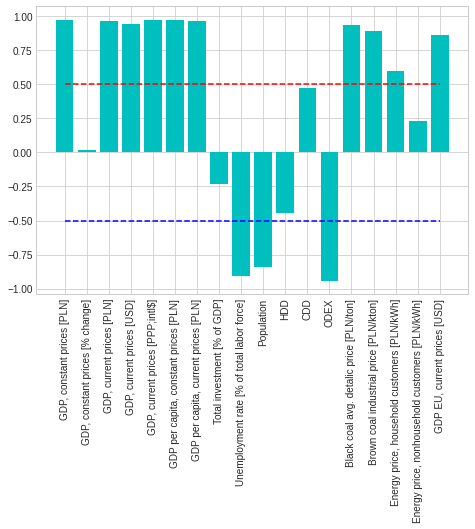

In [51]:
demand_correlations = corr['Electricity demand'][1:]
colnames = corr.columns[1:].to_list()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticklabels(labels=colnames, rotation=90)
ax.bar(colnames, demand_correlations, color='c')
plt.plot(np.repeat(0.5, len(colnames)), 'r--')
plt.plot(np.repeat(-0.5, len(colnames)), 'b--')
plt.show()

## Compute percentage changes

In [52]:
percent_changes = all_data.pct_change()
percent_changes.describe().loc[['mean', 'min', 'max', 'std']]

,Electricity demand,"GDP, constant prices [PLN]","GDP, constant prices [% change]","GDP, current prices [PLN]","GDP, current prices [USD]","GDP, current prices [PPP;intl$]","GDP per capita, constant prices [PLN]","GDP per capita, current prices [PLN]",Total investment [% of GDP],Unemployment rate [% of total labor force],Population,HDD,CDD,ODEX,Black coal avg. detalic price [PLN/ton],Brown coal industrial price [PLN/kton],"Energy price, household customers [PLN/kWh]","Energy price, nonhousehold customers [PLN/kWh]","GDP EU, current prices [USD]"
mean,0.009469,0.034685,0.082684,0.061457,0.067298,0.054806,0.035605,0.062421,-0.013562,-0.053586,-0.000878,-0.001948,0.749546,-0.015661,0.070699,0.042501,0.022488,0.032723,0.035124
min,-0.040405,-0.027234,-1.599648,0.012829,-0.175798,-0.015440,-0.026858,0.013221,-0.165889,-0.306220,-0.010448,-0.154750,-0.858657,-0.047230,-0.025288,-0.062347,-0.126678,-0.085298,-0.134333
max,0.042154,0.070614,1.974472,0.118208,0.244885,0.099376,0.071502,0.130005,0.162284,0.224930,0.001052,0.156118,7.410839,0.000000,0.249288,0.171801,0.165998,0.261979,0.229048
std,0.020055,0.021267,0.748080,0.028563,0.107417,0.025160,0.021646,0.029731,0.085706,0.154189,0.002325,0.078502,1.958238,0.011336,0.070591,0.063510,0.076997,0.102502,0.089934


In [53]:
percent_changes

,Electricity demand,"GDP, constant prices [PLN]","GDP, constant prices [% change]","GDP, current prices [PLN]","GDP, current prices [USD]","GDP, current prices [PPP;intl$]","GDP per capita, constant prices [PLN]","GDP per capita, current prices [PLN]",Total investment [% of GDP],Unemployment rate [% of total labor force],Population,HDD,CDD,ODEX,Black coal avg. detalic price [PLN/ton],Brown coal industrial price [PLN/kton],"Energy price, household customers [PLN/kWh]","Energy price, nonhousehold customers [PLN/kWh]","GDP EU, current prices [USD]"
Year,,,,,,,,,,,,,,,,,,,
1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,0.012409,0.042597,-0.058355,0.118208,0.020716,0.065903,0.053597,0.130005,-0.016108,0.224930,-0.010448,-0.067979,0.359195,-0.008007,0.166824,0.148865,NaN,NaN,-0.082694
2001,-0.001449,0.012053,-0.717136,0.047269,0.111833,0.034249,0.012300,0.047525,-0.164571,0.133959,-0.000235,0.156118,0.228330,-0.008072,0.142972,0.110350,NaN,NaN,0.015495
2002,-0.012173,0.014434,0.197510,0.039834,0.043316,0.030484,0.014746,0.040153,-0.100376,0.092753,-0.000314,-0.068009,0.750430,-0.047230,0.125088,0.120731,NaN,NaN,0.092656
2003,0.032497,0.034985,1.424116,0.043016,0.094233,0.054204,0.035625,0.043662,0.021511,-0.014598,-0.000601,0.075572,-0.570305,-0.033838,0.111181,-0.009524,NaN,NaN,0.229048
2004,0.024746,0.049828,0.424528,0.101446,0.171984,0.078090,0.050596,0.102251,0.075778,-0.034058,-0.000733,-0.022868,-0.689931,-0.027592,0.100056,0.004274,NaN,NaN,0.149582
2005,0.005338,0.035067,-0.296207,0.061557,0.199818,0.067306,0.035522,0.062024,-0.016906,-0.064773,-0.000445,0.008181,3.158672,-0.023499,0.090956,0.021277,NaN,NaN,0.044082
2006,0.034583,0.061311,0.748218,0.079654,0.125114,0.093431,0.061778,0.080130,0.090004,-0.219893,-0.000445,-0.023013,1.916593,-0.021873,0.083373,0.020833,NaN,NaN,0.067064
2007,0.028849,0.070614,0.151851,0.110414,0.244885,0.099376,0.071502,0.111330,0.162284,-0.306220,-0.000839,-0.066557,-0.430179,-0.018731,0.076956,0.024490,NaN,NaN,0.158981


## Plot demand and criteria data

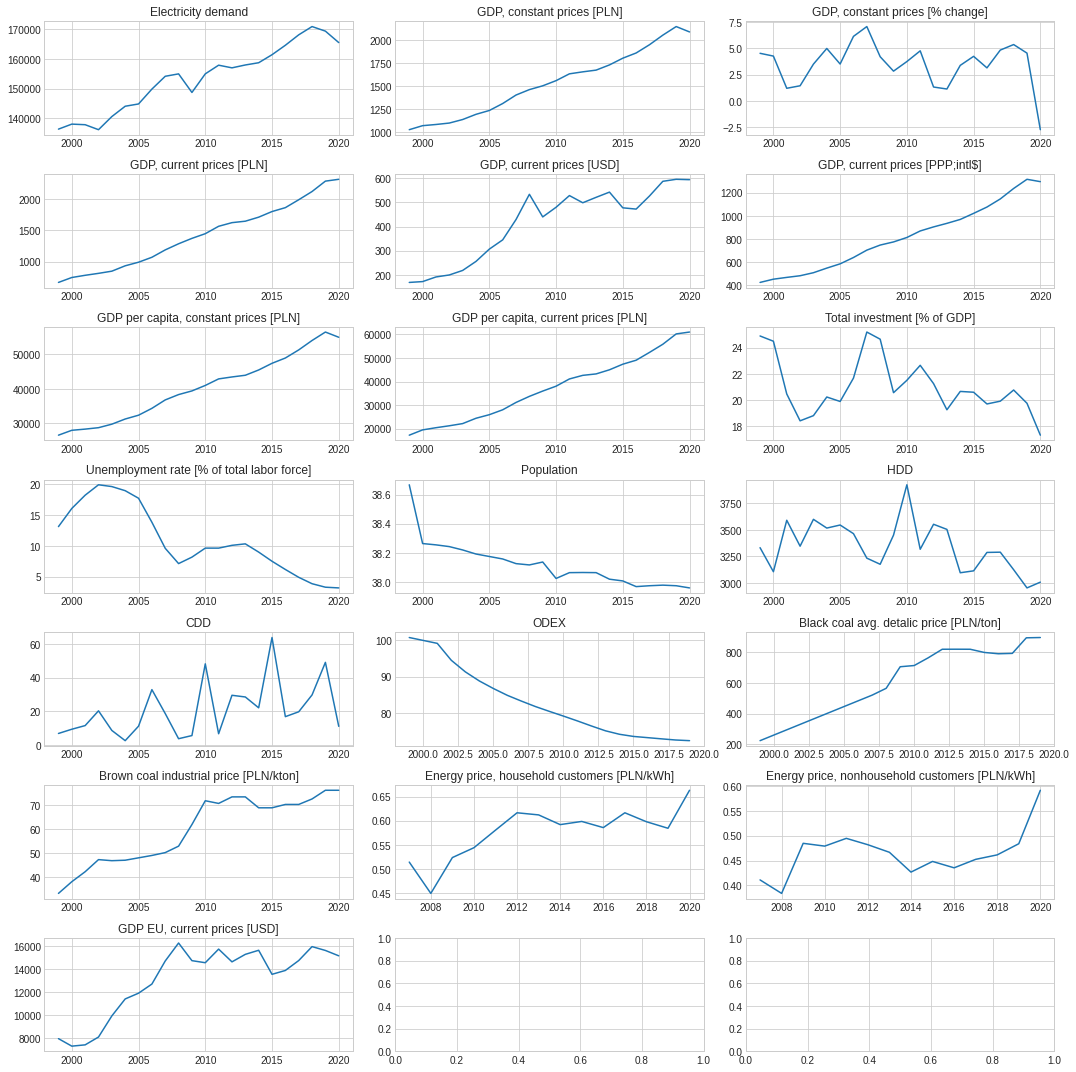

In [54]:
def plot_all_data(_data):
    plot_num = _data.shape[1]
    _row = 3
    fig, ax = plt.subplots(int(np.ceil(plot_num / _row)), _row, figsize=(15, 15))

    CL = _data.columns.tolist()

    for i in range(plot_num):
        ax[i // _row, i % _row].plot(_data[CL[i]])
        ax[i // _row, i % _row].set_title(CL[i])

    fig.tight_layout()

plot_all_data(all_data)

## fill lacking data for 2020 with previous year data 

In [55]:
jagged_2020 = all_data.loc[2020].isna()
jagged_columns = all_data.columns[jagged_2020]

for col in jagged_columns:
    all_data.at[2020, col] = all_data.at[2019, col]

if sum(all_data.loc[2020].isna()):
    print("something went wrong")
else:
    print("Lacking data for 2020 filled with values from 2019")

Lacking data for 2020 filled with values from 2019


## fill lacking data for previous years 

In [56]:
jagged_columns = all_data.describe().loc['count'] < all_data.shape[0]
jagged_columns = all_data.columns[jagged_columns]
jagged_columns

Index(['Energy price, household customers [PLN/kWh]', 'Energy price, nonhousehold customers [PLN/kWh]'], dtype='object')

In [57]:
jagged_corred = {}
for jc in jagged_columns:
    _corrs = corr[jc].abs().sort_values()
    _corrs = _corrs.drop(jagged_columns)
    max_corr = _corrs.idxmax()
    jagged_corred[jc] = max_corr

jagged_corred

{'Energy price, household customers [PLN/kWh]': 'Black coal avg. detalic price [PLN/ton]',
 'Energy price, nonhousehold customers [PLN/kWh]': 'GDP, constant prices [% change]'}

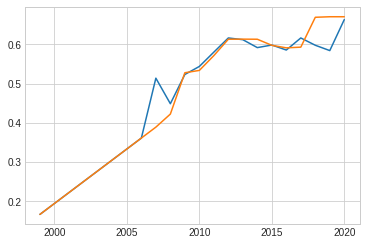

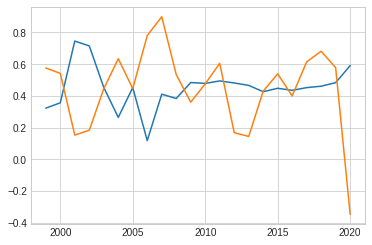

In [58]:
for jc in jagged_corred:
    jagged = jc
    support = jagged_corred[jc]

    jagged_data = all_data[jc]
    support_data = all_data[support]

    if corr.at[jagged, support] < 0:
        support_data = all_data[support].max() - all_data[support]

    _known = jagged_data.notna()
    _unknown = jagged_data.isna()

    c = jagged_data[_known].mean() / support_data[_known].mean()

    artificial_data = c * support_data[_unknown]
    new_data = pd.concat([artificial_data, jagged_data[_known]])

    all_data[jc].loc[_unknown] = new_data

    plt.plot(all_data[jc])
    plt.plot(all_data[support]*c)
    plt.show()


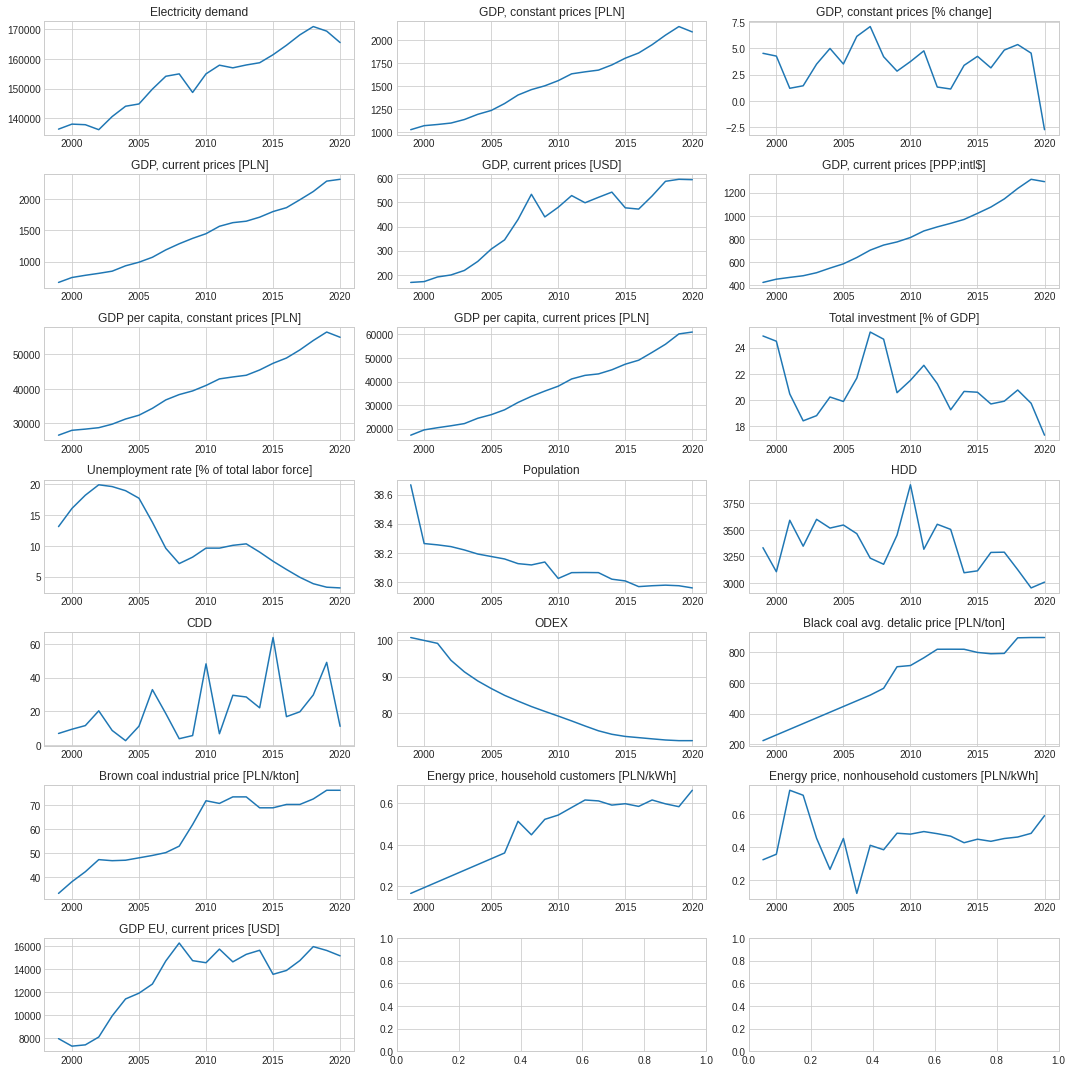

In [59]:
plot_all_data(all_data)

## Criteria selection

In [60]:
print('\n'.join([ f'\"{c}\"' for i, c in enumerate(all_data.columns)]))

"Electricity demand"
"GDP, constant prices [PLN]"
"GDP, constant prices [% change]"
"GDP, current prices [PLN]"
"GDP, current prices [USD]"
"GDP, current prices [PPP;intl$]"
"GDP per capita, constant prices [PLN]"
"GDP per capita, current prices [PLN]"
"Total investment [% of GDP]"
"Unemployment rate [% of total labor force]"
"Population"
"HDD"
"CDD"
"ODEX"
"Black coal avg. detalic price [PLN/ton]"
"Brown coal industrial price [PLN/kton]"
"Energy price, household customers [PLN/kWh]"
"Energy price, nonhousehold customers [PLN/kWh]"
"GDP EU, current prices [USD]"


In [61]:
selected_criteria_names = [
"Electricity demand",
"GDP, constant prices [PLN]",
"GDP EU, current prices [USD]",
"Unemployment rate [% of total labor force]",
"Population",
"HDD",
#"CDD",
"ODEX",
"Black coal avg. detalic price [PLN/ton]",
"Brown coal industrial price [PLN/kton]",
"Energy price, household customers [PLN/kWh]"
]

selected_data = all_data[selected_criteria_names]
selected_data.to_csv(f'selected_data{mods}.csv')

In [62]:
# selected_data.describe()
short_names = [
"Zapotrzebowanie el.",
"PKB",
"PKB UE",
"Bezrobocie",
"Populacja",
"HDD",
#"CDD",
"ODEX",
"Cena węgla kamienego",
"Cena węgla brunatnego",
"Cena energii"]

old_names = selected_data.columns
selected_data.columns = short_names
corr = selected_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
pd.set_option('display.max_colwidth', 40)

def style_negative(v, props=''):
    return props if v < 0 else None
def style_positive(v, props=''):
    return props if v  >0 else None
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')


corr.style.applymap(style_negative, props='color:white;background-color:blue;')\
        .applymap(style_positive, props='color:white;background-color:red;') \
        .applymap(lambda v: 'opacity: 60%;' if abs(v) < 0.95 else None) \
        .applymap(lambda v: 'opacity: 50%;' if abs(v) < 0.9 else None) \
        .applymap(lambda v: 'opacity: 40%;' if abs(v) < 0.8 else None) \
        .applymap(lambda v: 'opacity: 30%;' if abs(v) < 0.6 else None) \
        .apply(highlight_max, props='color:black;background-color:white', axis=0) \
        .set_precision(3) \
        .set_properties(subset=selected_data.columns, **{'width': '75px' ,'height': '30px'})

#corr.style.background_gradient(cmap='coolwarm').set_precision(3) \
#    .set_properties(subset=selected_data.columns, **{'width': '100px' ,'height': '30px'})


,Zapotrzebowanie el.,PKB,PKB UE,Bezrobocie,Populacja,HDD,ODEX,Cena węgla kamienego,Cena węgla brunatnego,Cena energii
Zapotrzebowanie el.,1.000,0.975,0.863,-0.906,-0.842,-0.441,-0.949,0.937,0.893,0.923
PKB,0.975,1.000,0.807,-0.908,-0.827,-0.482,-0.935,0.955,0.922,0.915
PKB UE,0.863,0.807,1.000,-0.804,-0.774,-0.243,-0.920,0.882,0.827,0.912
Bezrobocie,-0.906,-0.908,-0.804,1.000,0.644,0.532,0.831,-0.852,-0.783,-0.848
Populacja,-0.842,-0.827,-0.774,0.644,1.000,0.234,0.882,-0.855,-0.862,-0.856
HDD,-0.441,-0.482,-0.243,0.532,0.234,1.000,0.303,-0.315,-0.205,-0.277
ODEX,-0.949,-0.935,-0.920,0.831,0.882,0.303,1.000,-0.975,-0.944,-0.973
Cena węgla kamienego,0.937,0.955,0.882,-0.852,-0.855,-0.315,-0.975,1.000,0.981,0.976
Cena węgla brunatnego,0.893,0.922,0.827,-0.783,-0.862,-0.205,-0.944,0.981,1.000,0.954
Cena energii,0.923,0.915,0.912,-0.848,-0.856,-0.277,-0.973,0.976,0.954,1.000


In [63]:
percent_changes = selected_data.pct_change()
percent_changes.describe().loc[['mean', 'min', 'max', 'std']]

,Zapotrzebowanie el.,PKB,PKB UE,Bezrobocie,Populacja,HDD,ODEX,Cena węgla kamienego,Cena węgla brunatnego,Cena energii
mean,0.009469,0.034685,0.035124,-0.053586,-0.000878,-0.001948,-0.015661,0.070699,0.042501,0.073101
min,-0.040405,-0.027234,-0.134333,-0.306220,-0.010448,-0.154750,-0.047230,-0.025288,-0.062347,-0.126678
max,0.042154,0.070614,0.229048,0.224930,0.001052,0.156118,0.000000,0.249288,0.171801,0.422340
std,0.020055,0.021267,0.089934,0.154189,0.002325,0.078502,0.011336,0.070591,0.063510,0.110766


In [64]:
_levels_ranges = {
"Electricity demand": [-3.5, 3.5],
"GDP, constant prices [PLN]": [-2.5, 5.0],
"GDP EU, current prices [Gross domestic product, current prices]": [-8.0, 8.0],
"Unemployment rate [% of total labor force]": [-20.0, 20.0],
"Population": [-2.0, 1.0],
"HDD": [-15.0, 15.0],
#"CDD": [-30.0, 50.0],
"ODEX": [-5.0, 0.0],
"Black coal avg. detalic price [PLN/ton]": [-5.0, 10.0],
"Brown coal industrial price [PLN/kton]": [-5.0, 10.0],
"Energy price, household customers [PLN/kWh]": [-10.0, 20.0]
}

levels_ranges = pd.DataFrame(_levels_ranges)
levels_ranges['idx'] = ['lower', 'upper']
levels_ranges = levels_ranges.set_index('idx')
levels_ranges = levels_ranges.append(pd.Series(name='is_gain'))
levels_ranges


/home/panturek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Electricity demand,"GDP, constant prices [PLN]","GDP EU, current prices [Gross domestic product, current prices]",Unemployment rate [% of total labor force],Population,HDD,ODEX,Black coal avg. detalic price [PLN/ton],Brown coal industrial price [PLN/kton],"Energy price, household customers [PLN/kWh]"
idx,,,,,,,,,,
lower,-3.5,-2.5,-8.0,-20.0,-2.0,-15.0,-5.0,-5.0,-5.0,-10.0
upper,3.5,5.0,8.0,20.0,1.0,15.0,0.0,10.0,10.0,20.0
is_gain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
levels_ranges = levels_ranges.fillna(value=1.0)
cost_criteria = ["Unemployment rate [% of total labor force]", "Energy price, household customers [PLN/kWh]"]

In [66]:
for ni in cost_criteria:
    levels_ranges.at['is_gain', ni] = 0.0
levels_ranges

,Electricity demand,"GDP, constant prices [PLN]","GDP EU, current prices [Gross domestic product, current prices]",Unemployment rate [% of total labor force],Population,HDD,ODEX,Black coal avg. detalic price [PLN/ton],Brown coal industrial price [PLN/kton],"Energy price, household customers [PLN/kWh]"
idx,,,,,,,,,,
lower,-3.5,-2.5,-8.0,-20.0,-2.0,-15.0,-5.0,-5.0,-5.0,-10.0
upper,3.5,5.0,8.0,20.0,1.0,15.0,0.0,10.0,10.0,20.0
is_gain,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [67]:
levels_ranges.to_csv(f'levels_ranges{mods}.csv')

# data extrapolation

In [68]:
prognosis = criteria[selected_criteria_names[1:]].loc[2021:]
prognosis

,"GDP, constant prices [PLN]","GDP EU, current prices [USD]",Unemployment rate [% of total labor force],Population,HDD,ODEX,Black coal avg. detalic price [PLN/ton],Brown coal industrial price [PLN/kton],"Energy price, household customers [PLN/kWh]"
Year,,,,,,,,,
2021,2158.790,17127.535,4.860,37.928,NaN,NaN,NaN,76.4,NaN
2022,2256.860,18283.894,4.543,37.890,NaN,NaN,NaN,NaN,NaN
2023,2346.621,19032.779,4.463,37.844,NaN,NaN,NaN,NaN,NaN
2024,2417.309,19757.615,4.463,37.789,NaN,NaN,NaN,NaN,NaN
2025,2486.324,20462.339,4.459,37.725,NaN,NaN,NaN,NaN,NaN
2026,2550.065,21183.949,4.456,37.651,NaN,NaN,NaN,NaN,NaN


In [69]:
extrap_base = all_data[selected_criteria_names[1:]].loc[2010:2020]
nancols = prognosis.isna().any()
extrap_ = extrap_base[prognosis.columns[nancols]]

In [70]:
def lin_extrapolate(df):
    x = df.index
    linear_model_functions = {}
    for c in df.columns:
        y = df[c]
        linear_model = np.polyfit(x, y, 1)
        linear_model_fn = np.poly1d(linear_model)
        linear_model_functions[c] = linear_model_fn
    return linear_model_functions

lin_models = lin_extrapolate(extrap_)

In [71]:
x_s = prognosis.index
for c in extrap_.columns:
    print(lin_models[c](x_s))
    prognosis[c] = lin_models[c](x_s)
prognosis

[2874.432      2805.68627273 2736.94054545 2668.19481818 2599.44909091
 2530.70336364]
[70.43078    69.76840091 69.10602182 68.44364273 67.78126364 67.11888455]
[906.07309091 920.48981818 934.90654545 949.32327273 963.74
 978.15672727]
[74.23054545 74.56290909 74.89527273 75.22763636 75.56       75.89236364]
[0.62959455 0.63468    0.63976545 0.64485091 0.64993636 0.65502182]


,"GDP, constant prices [PLN]","GDP EU, current prices [USD]",Unemployment rate [% of total labor force],Population,HDD,ODEX,Black coal avg. detalic price [PLN/ton],Brown coal industrial price [PLN/kton],"Energy price, household customers [PLN/kWh]"
Year,,,,,,,,,
2021,2158.790,17127.535,4.860,37.928,2874.432000,70.430780,906.073091,74.230545,0.629595
2022,2256.860,18283.894,4.543,37.890,2805.686273,69.768401,920.489818,74.562909,0.634680
2023,2346.621,19032.779,4.463,37.844,2736.940545,69.106022,934.906545,74.895273,0.639765
2024,2417.309,19757.615,4.463,37.789,2668.194818,68.443643,949.323273,75.227636,0.644851
2025,2486.324,20462.339,4.459,37.725,2599.449091,67.781264,963.740000,75.560000,0.649936
2026,2550.065,21183.949,4.456,37.651,2530.703364,67.118885,978.156727,75.892364,0.655022


In [72]:
prognosis.to_csv(f'pl_forecast{mods}.csv')

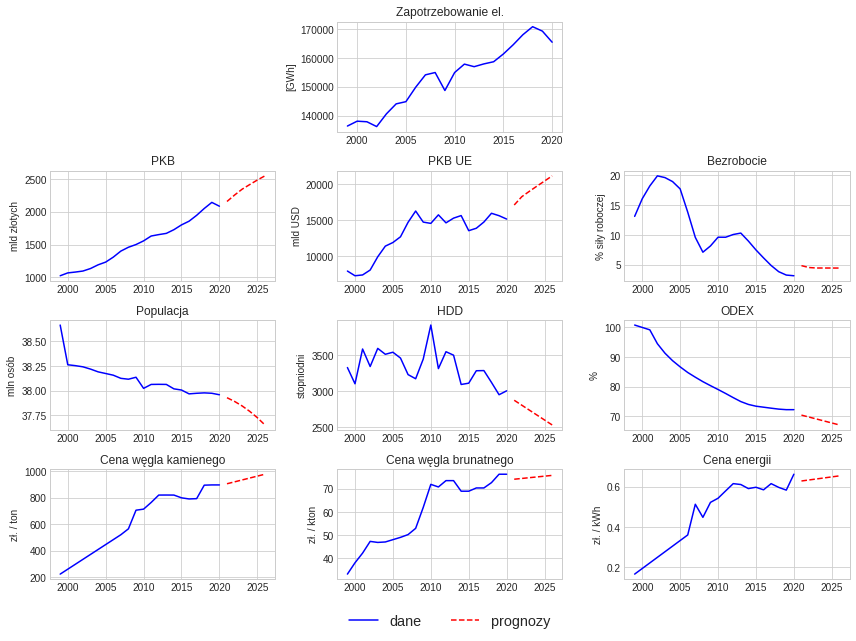

In [73]:
def plot_selected_data(data, prog, seleted, names):
    fig, ax = plt.subplots(int(np.ceil(len(names) / 3)), 3, figsize=(12, 9))
    __colnames = data.columns
    ax[0, 0].axis('off')
    ax[0, 2].axis('off')
    ax[0, 1].plot(data['Electricity demand'], 'b')
    ax[0, 1].set_title('Zapotrzebowanie el.')
    ax[0, 1].set_ylabel('[GWh]')
    units = [
        'mld złotych',
        'mld USD',
        '% siły roboczej',
        'mln osób',
        'stopniodni',
        '%',
        'zł. / ton',
        'zł. / kton',
        'zł. / kWh',
    ]

    for index in range(3, len(names)+ 2):
        curr_ax = ax[index // 3, index % 3]
        curr_ax.plot(data[selected_criteria_names[index-2]], 'b-')
        curr_ax.plot(prog[selected_criteria_names[index-2]], 'r--')
        curr_ax.set_title(names[index-2])
        curr_ax.set_ylabel(units[index-3])
    ax[-1, 1].legend(['dane', 'prognozy'], loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=3, fontsize='x-large' )

    plt.style.use('seaborn-whitegrid')
    fig.tight_layout()
    plt.savefig(f'selected_data{mods}.png')

plot_selected_data(all_data, prognosis, selected_criteria_names, short_names)

In [74]:
selected_data.pct_change()

,Zapotrzebowanie el.,PKB,PKB UE,Bezrobocie,Populacja,HDD,ODEX,Cena węgla kamienego,Cena węgla brunatnego,Cena energii
Year,,,,,,,,,,
1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,0.012409,0.042597,-0.082694,0.224930,-0.010448,-0.067979,-0.008007,0.166824,0.148865,0.166824
2001,-0.001449,0.012053,0.015495,0.133959,-0.000235,0.156118,-0.008072,0.142972,0.110350,0.142972
2002,-0.012173,0.014434,0.092656,0.092753,-0.000314,-0.068009,-0.047230,0.125088,0.120731,0.125088
2003,0.032497,0.034985,0.229048,-0.014598,-0.000601,0.075572,-0.033838,0.111181,-0.009524,0.111181
2004,0.024746,0.049828,0.149582,-0.034058,-0.000733,-0.022868,-0.027592,0.100056,0.004274,0.100056
2005,0.005338,0.035067,0.044082,-0.064773,-0.000445,0.008181,-0.023499,0.090956,0.021277,0.090956
2006,0.034583,0.061311,0.067064,-0.219893,-0.000445,-0.023013,-0.021873,0.083373,0.020833,0.083373
2007,0.028849,0.070614,0.158981,-0.306220,-0.000839,-0.066557,-0.018731,0.076956,0.024490,0.422340
